Saving chessboard_800x800.png to chessboard_800x800 (1).png
Saving Three_horizontal_stripes.svg.png to Three_horizontal_stripes.svg (1).png


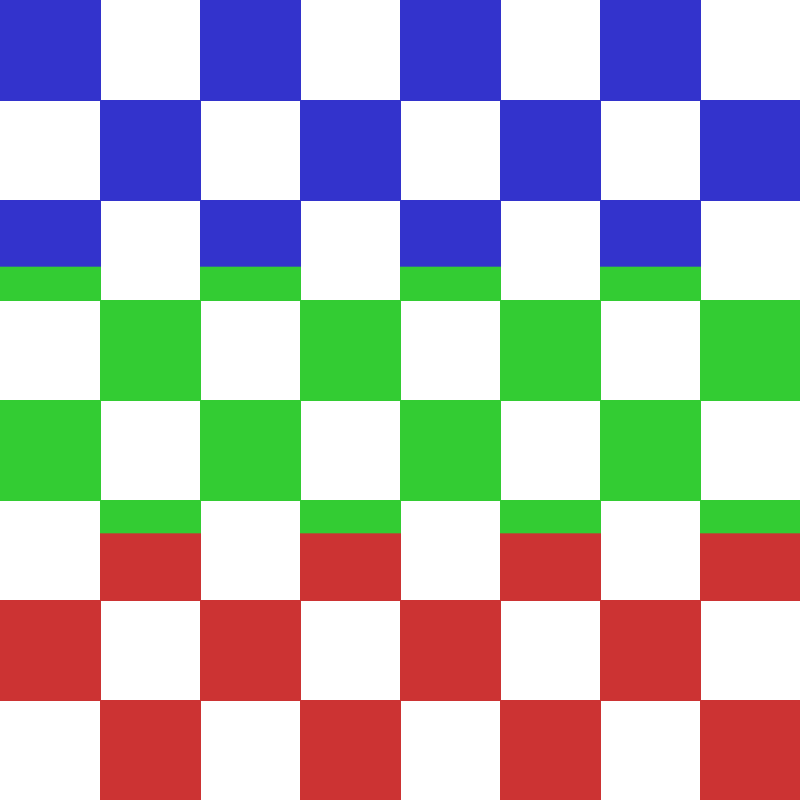

In [ ]:
from google.colab import files
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


uploaded = files.upload()
filenames = list(uploaded.keys())
chess_img = cv2.imread(filenames[0])  # chess image
carpet_img = cv2.imread(filenames[1])  # carpet image

# In case the pixels are "almost black"
threshold = 50

# Resize carpet image
carpet_img = cv2.resize(carpet_img, (chess_img.shape[1], chess_img.shape[0]))

# Blank image
result_img = np.full_like(chess_img, 255)


height, width = chess_img.shape[:2]

for i in range(height):
    for j in range(width):
        pixel = chess_img[i, j]
        if np.all(pixel < threshold):
            result_img[i, j] = carpet_img[i, j]


cv2_imshow(result_img)




Saving shotmarilynstock.jpg to shotmarilynstock.jpg
Using K = 4


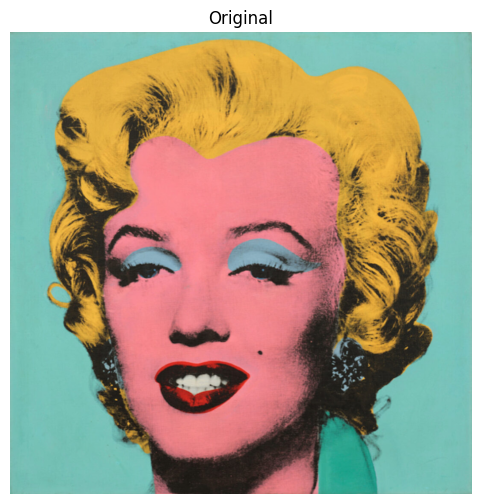

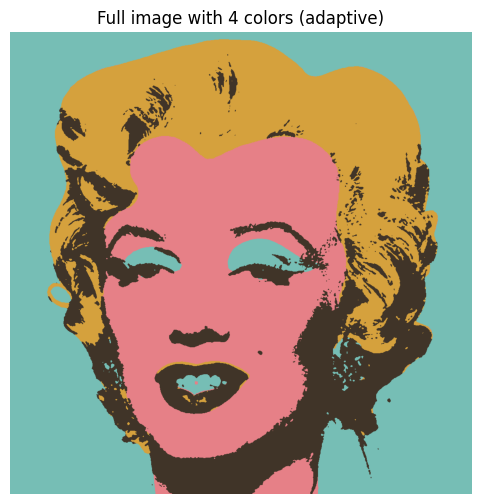

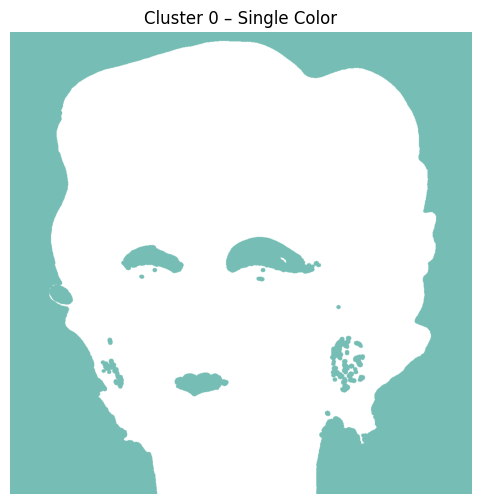

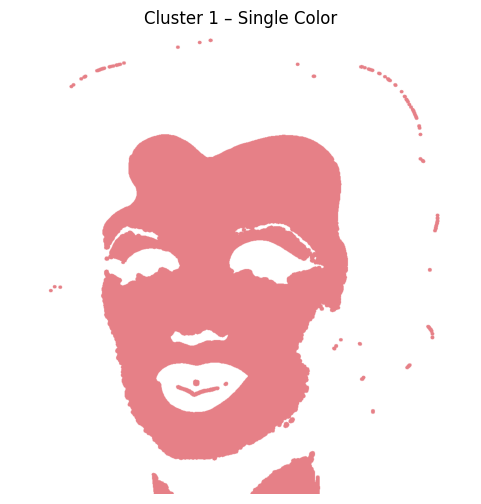

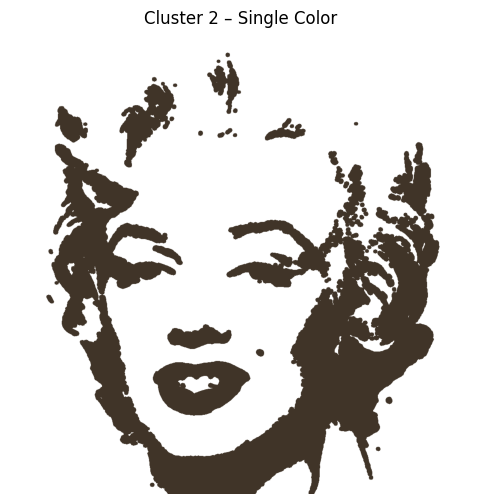

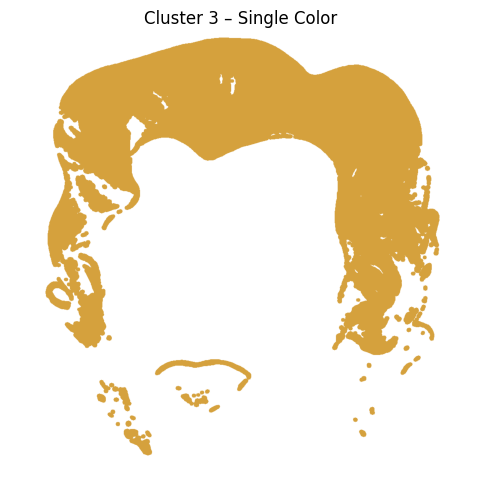

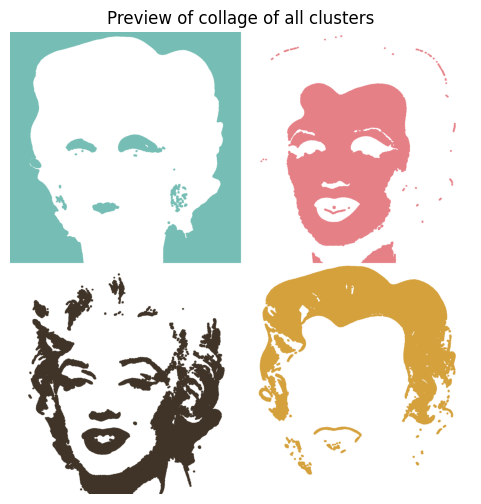


Files saved to: /content/kmeans_output_adaptive


In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import files

# SETTINGS
AUTO_K         = True       # auto K choice with Davies–Bouldin (DBI)
K_MIN, K_MAX   = 3, 12      # range for auto-K
K_DEFAULT      = 4          # manual Κ if AUTO_K=False
COLORSPACE     = "RGB"      # "RGB"

LABEL_SMOOTH   = True       # median
SMOOTH_KSIZE   = 3          # 3 or 5

# ---- Για “χωρίς ραφές” στο κολλάζ ----
OVERLAP_PX     = 4          # overlap extension (3-5px)
USE_CLOSE      = True       # smooth MORPH_CLOSE in the edges
CLOSE_KSIZE    = 5

SAMPLE_PX        = 200_000  # Sample of  pixels for fast  auto-K in big pictures
KMEANS_ATTEMPTS  = 5
MAX_ITERS        = 40       # maximum k-means reps

def show(img, title=""):
    """Show RGB Image."""
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

def kmeans_once(pixels_f32, K):
    """Implements k-means and returns labels and centers."""
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, MAX_ITERS, 1.0)
    _, labels, centers = cv2.kmeans(
        data=pixels_f32,
        K=K,
        bestLabels=None,
        criteria=criteria,
        attempts=KMEANS_ATTEMPTS,
        flags=cv2.KMEANS_PP_CENTERS
    )
    return labels.reshape(-1), centers.astype(np.float32)

def dbi(pixels_f32, labels, centers):
    """Davies–Bouldin Index."""
    K = centers.shape[0]
    if K < 2:
        return float("inf")
    # mean points distance of every cluster from each center
    Si = np.zeros(K, np.float32)
    for i in range(K):
        pts = pixels_f32[labels == i]
        if pts.size == 0:
            Si[i] = 0.0
        else:
            dif = pts - centers[i]
            dist = np.sqrt(np.sum(dif * dif, axis=1))
            Si[i] = np.mean(dist)
    # distances from the center
    diff = centers[None, :, :] - centers[:, None, :]
    M = np.sqrt(np.sum(diff * diff, axis=2)) + 1e-8
    # R_ij and D_i
    R = (Si[:, None] + Si[None, :]) / M
    np.fill_diagonal(R, -np.inf)
    D = np.max(R, axis=1)
    return float(np.mean(D))

def choose_best_K(work_img):
    """Checks Κ∈[K_MIN, K_MAX] and keeps the smallest DBI."""
    pixels = work_img.reshape(-1, 3).astype(np.float32)
    # for big images
    if pixels.shape[0] > SAMPLE_PX:
        idx = np.random.choice(pixels.shape[0], SAMPLE_PX, replace=False)
        sample = pixels[idx]
    else:
        sample = pixels
    best_K, best_score = None, float("inf")
    for K in range(K_MIN, K_MAX + 1):
        lbls, ctrs = kmeans_once(sample, K)
        score = dbi(sample, lbls, ctrs)
        if score < best_score:
            best_K, best_score = K, score
    return best_K

def center_to_rgb(center, space_name):
    """Changes to RGB."""
    patch = np.uint8([[center]])
    if space_name == "LAB":
        return cv2.cvtColor(patch, cv2.COLOR_Lab2RGB)[0, 0]
    if space_name == "HSV":
        return cv2.cvtColor(patch, cv2.COLOR_HSV2RGB)[0, 0]
    return patch[0, 0]

# upload image
uploaded = files.upload()
IMAGE_PATH = list(uploaded.keys())[0]

bgr = cv2.imread(IMAGE_PATH)
if bgr is None:
    raise FileNotFoundError("Failed reading Image.")
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
h, w = rgb.shape[:2]


space = COLORSPACE.upper()
if space == "LAB":
    work = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
elif space == "HSV":
    work = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
else:
    work = rgb.copy()

# k option (auto or manually)
K = choose_best_K(work) if AUTO_K else K_DEFAULT
print(f"Using K = {K}")

# k-means in full image
pixels_full = work.reshape(-1, 3).astype(np.float32)
labels_flat, centers = kmeans_once(pixels_full, K)
label_img = labels_flat.reshape(h, w).astype(np.uint8)
centers_u8 = centers.astype(np.uint8)

if LABEL_SMOOTH and SMOOTH_KSIZE >= 3 and SMOOTH_KSIZE % 2 == 1:
    label_img = cv2.medianBlur(label_img, SMOOTH_KSIZE)


quantized = centers_u8[label_img.reshape(-1)].reshape(h, w, 3)
if space == "LAB":
    quantized_rgb = cv2.cvtColor(quantized, cv2.COLOR_Lab2RGB)
elif space == "HSV":
    quantized_rgb = cv2.cvtColor(quantized, cv2.COLOR_HSV2RGB)
else:
    quantized_rgb = quantized.copy()

# output folder
OUT = Path("kmeans_output_adaptive")
OUT.mkdir(exist_ok=True)


close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (CLOSE_KSIZE, CLOSE_KSIZE)) if USE_CLOSE else None
overlap_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*OVERLAP_PX+1, 2*OVERLAP_PX+1)) if OVERLAP_PX > 0 else None

# masks and RGBA
cluster_rgba_list = []
union_mask = np.zeros((h, w), np.uint8)

for j in range(K):
    base_mask = np.where(label_img == j, 255, 0).astype(np.uint8)

    # for clean edges
    if close_kernel is not None:
        base_mask = cv2.morphologyEx(base_mask, cv2.MORPH_CLOSE, close_kernel)

    # overlap for zero holes
    alpha_mask = cv2.dilate(base_mask, overlap_kernel) if overlap_kernel is not None else base_mask.copy()
    alpha_mask = np.where(alpha_mask > 0, 255, 0).astype(np.uint8)


    color_rgb = center_to_rgb(centers_u8[j], space)
    flat = np.zeros_like(rgb)
    flat[alpha_mask == 255] = color_rgb

    # store files
    cv2.imwrite(str(OUT / f"mask_cluster_{j}_tight.png"), base_mask)
    if OVERLAP_PX > 0:
        cv2.imwrite(str(OUT / f"mask_cluster_{j}_overlap{OVERLAP_PX}px.png"), alpha_mask)

    rgba = np.dstack([flat, alpha_mask])
    cv2.imwrite(
        str(OUT / f"cluster_{j}_transparent_overlap{OVERLAP_PX}px.png"),
        cv2.cvtColor(rgba, cv2.COLOR_RGBA2BGRA)
    )
    cluster_rgba_list.append(rgba)

    union_mask = cv2.bitwise_or(union_mask, base_mask)


if np.any(union_mask == 0):
    work_vec = work.reshape(-1, 3).astype(np.float32)
    centers_f = centers_u8.astype(np.float32)
    residual_flat = (union_mask == 0).reshape(-1)
    ridx = np.where(residual_flat)[0]
    # distance from every uncovered pixel from each center
    dif = work_vec[ridx][:, None, :] - centers_f[None, :, :]
    dist = np.sqrt(np.sum(dif * dif, axis=2))
    nearest = dist.argmin(axis=1).astype(np.uint8)
    lab_flat = label_img.reshape(-1)
    lab_flat[ridx] = nearest
    label_img = lab_flat.reshape(h, w)

# collage preview
cols = int(math.ceil(math.sqrt(K)))
rows = int(math.ceil(K / cols))
canvas = np.full((rows * h, cols * w, 3), 255, np.uint8)

for idx, rgba in enumerate(cluster_rgba_list):
    r, c = divmod(idx, cols)
    a = (rgba[:, :, 3:4].astype(np.float32)) / 255.0
    fg = rgba[:, :, :3].astype(np.float32)
    bg = canvas[r*h:r*h+h, c*w:c*w+w].astype(np.float32)
    canvas[r*h:r*h+h, c*w:c*w+w] = (fg * a + bg * (1.0 - a)).astype(np.uint8)

# store and display
cv2.imwrite(str(OUT / f"collage_preview_K{K}.png"), cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
cv2.imwrite(str(OUT / f"segmented_full_K{K}.png"), cv2.cvtColor(quantized_rgb, cv2.COLOR_RGB2BGR))

def preview_cluster(rgba, j):
    a = (rgba[:, :, 3:4].astype(np.float32)) / 255.0
    fg = rgba[:, :, :3].astype(np.float32)
    preview = (fg * a + 255.0 * (1.0 - a)).astype(np.uint8)
    show(preview, f"Cluster {j} – Single Color")

show(rgb, "Original")
show(quantized_rgb, f"Full image with {K} colors (adaptive)")
for j, rgba in enumerate(cluster_rgba_list):
    preview_cluster(rgba, j)
show(canvas, "Preview of collage of all clusters")

print("\nFiles saved to:", OUT.resolve())
